# Forecast Gold Prices

## Business Objective:


### Data provided is related to gold prices. The objective is to understand the underlying structure in your dataset and come up with a suitable forecasting model which can effectively forecast gold prices for next 30 days.
### This forecast model will be used by gold exporting and gold importing companies to understand the metal price movements and accordingly set their revenue expectations.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from math import sqrt
import statsmodels.api as smf
import pandas_profiling as pp
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot
import statsmodels.formula.api as sm

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing,Holt 


import warnings
warnings.filterwarnings('ignore')

In [33]:
data=pd.read_csv('Gold_data.csv',parse_dates=True)
data.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


# Exploratory Data Analysis

## In Time Series Analysis we will analyze to find out the below stuff

- Missing values
- Duplicated values
- Outlier Detection
- Feature Scaling
- Feature Extraction
- Correlation
- Skewness Removal
- Data Insights
- Stationarity Test
- Autocorrelation Function
- Partial Autocorrelation Function
- Lag plots
- Normal Distribution Analysis
- Relationshop between independent and dependent feature (Price and date)

## Descriptive Analysis

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2182 non-null   object 
 1   price   2182 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.2+ KB


In [35]:
data.describe()

,price
count,2182.000000
mean,3284.450046
std,719.564434
min,2252.600000
25%,2697.020000
50%,2879.800000
75%,4147.325000
max,4966.300000


- As we can see,in the dataset the **minimum** gold price is 2252 and **maximum** is double i.e. 4966. 
- Average price is 3284.
- The diff between maximum and 75% is not out of bound hence we can say that there is no outlier present in the dataset.

In [36]:
data.isnull().sum()

date     0
price    0
dtype: int64

In [37]:
data.duplicated().sum()

0

In [38]:
data.isna().sum()

date     0
price    0
dtype: int64

-There is no null,duplicated and missing values in dataset.

In [39]:
print("Year starts from {} to {}".format(data.date[0],data.date.iloc[-1]))


Year starts from 2016-01-01 to 2021-12-21


- The data is from 2016 to 2021.
- 5 years gold price.

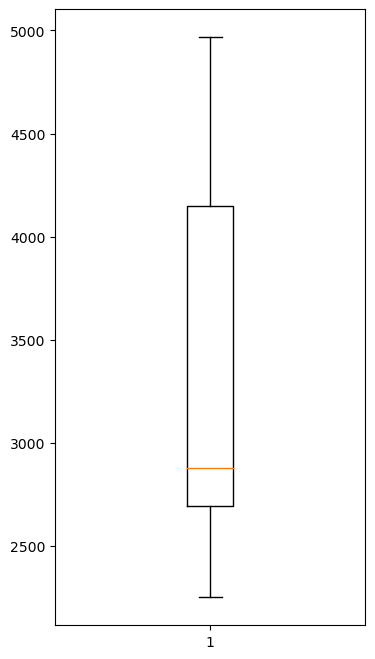

In [40]:
plt.figure(figsize=(4,8))
plt.boxplot(data.price)
plt.show()

- ## No outlier present in dataset

# Univariate Analysis
### Histogram PLot

In [41]:
df=data.copy()
df['date']=pd.to_datetime(df.date)#,format='%b-%y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2182 non-null   datetime64[ns]
 1   price   2182 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.2 KB


<AxesSubplot: >

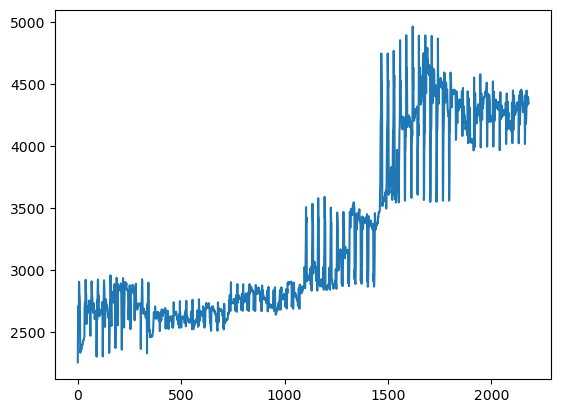

In [42]:
df.price.plot()

In [43]:
# month extraction
df['Month']=df.date.dt.strftime('%b')
# year extraction
df['Year']=df.date.dt.strftime('%Y')
df['quarter'] = df['date'].dt.quarter
df['dayno']=pd.to_datetime(df.date).dt.strftime('%d')
df['day_of_week'] = df['date'].dt.day_name()

df[['Month']]=df[['Month']].astype('str')
df[['Year']]=df[['Year']].astype(int)
df[['quarter']]=df[['quarter']].astype(int)
df[['day_of_week']]=df[['day_of_week']].astype(str)
df[['dayno']]=df[['dayno']].astype(int)

df.head(5)

,date,price,Month,Year,quarter,dayno,day_of_week
0,2016-01-01,2252.60,Jan,2016,1,1,Friday
1,2016-01-02,2454.50,Jan,2016,1,2,Saturday
2,2016-01-03,2708.10,Jan,2016,1,3,Sunday
3,2016-01-04,2577.80,Jan,2016,1,4,Monday
4,2016-01-05,2597.75,Jan,2016,1,5,Tuesday


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2182 non-null   datetime64[ns]
 1   price        2182 non-null   float64       
 2   Month        2182 non-null   object        
 3   Year         2182 non-null   int32         
 4   quarter      2182 non-null   int32         
 5   dayno        2182 non-null   int32         
 6   day_of_week  2182 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(3), object(2)
memory usage: 93.9+ KB


In [45]:
df['change']=df['price'].pct_change() 
df['Difference']=df['price'].diff() 
df.head()

,date,price,Month,Year,quarter,dayno,day_of_week,change,Difference
0,2016-01-01,2252.60,Jan,2016,1,1,Friday,NaN,NaN
1,2016-01-02,2454.50,Jan,2016,1,2,Saturday,0.089630,201.90
2,2016-01-03,2708.10,Jan,2016,1,3,Sunday,0.103320,253.60
3,2016-01-04,2577.80,Jan,2016,1,4,Monday,-0.048115,-130.30
4,2016-01-05,2597.75,Jan,2016,1,5,Tuesday,0.007739,19.95


In [46]:
df[['price','change','Difference']].describe()

,price,change,Difference
count,2182.000000,2181.000000,2181.000000
mean,3284.450046,0.000805,0.960064
std,719.564434,0.031395,113.947909
min,2252.600000,-0.249826,-1187.100000
25%,2697.020000,-0.005752,-18.300000
50%,2879.800000,0.000000,0.000000
75%,4147.325000,0.006973,22.800000
max,4966.300000,0.170527,687.800000


In [47]:
# To find information of maximum price
df[df['price']==4966.300000]

,date,price,Month,Year,quarter,dayno,day_of_week,change,Difference
1620,2020-06-08,4966.3,Jun,2020,2,8,Monday,0.160757,687.8


In [48]:
# To find information of minimum price
df[df['price']==2299.800000]

,date,price,Month,Year,quarter,dayno,day_of_week,change,Difference
91,2016-04-01,2299.8,Apr,2016,2,1,Friday,-0.125352,-329.6


**From the above we can say that the highest Gold price on thw 8th Jun 2020 and the lowest price on the 1st April 2016.**

In [49]:
df_year = df[['price','Year']].groupby(by='Year').mean().reset_index()
df_year

,Year,price
0,2016,2690.614162
1,2017,2626.676484
2,2018,2781.938082
3,2019,3150.210685
4,2020,4216.378689
5,2021,4266.871549


**Here we can see the average of every year**

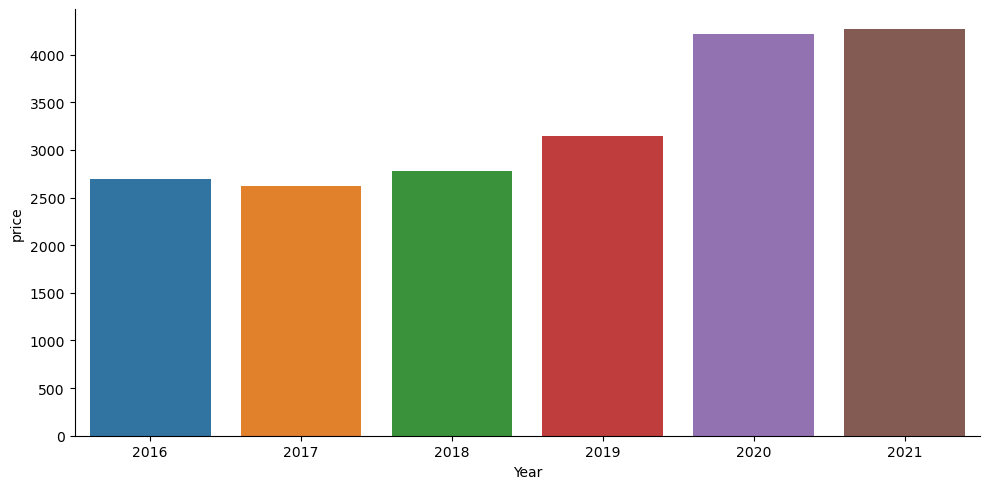

In [50]:
sns.catplot(x='Year',y='price',data=df_year,kind='bar',aspect=2)

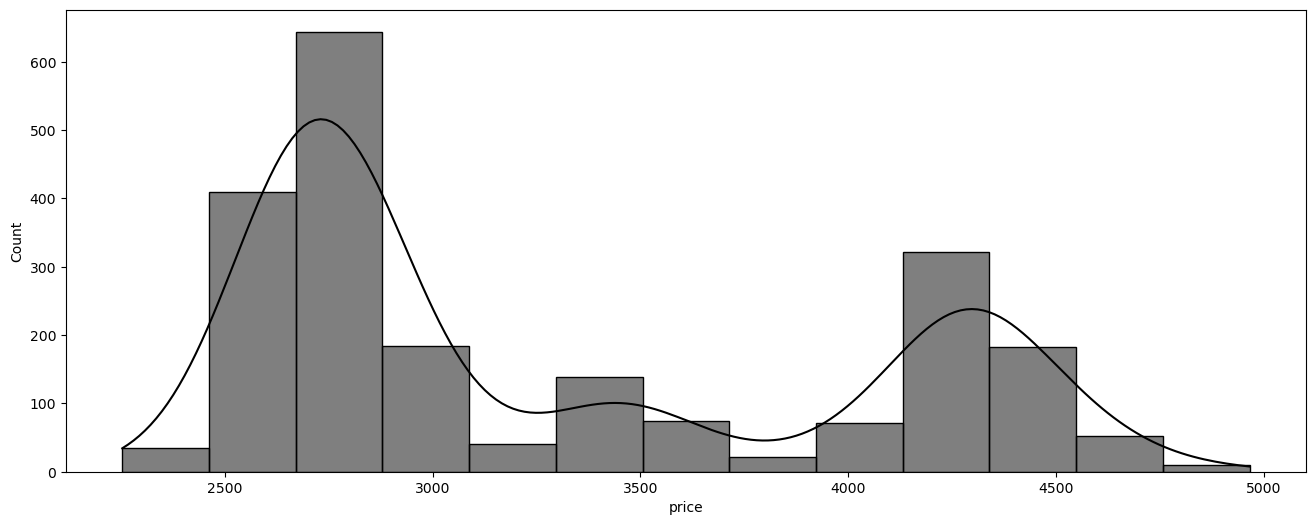

In [51]:
_, ax = plt.subplots(figsize=(16,6))
sns.histplot(data=df,x='price',kde=True,color='black')
plt.show()

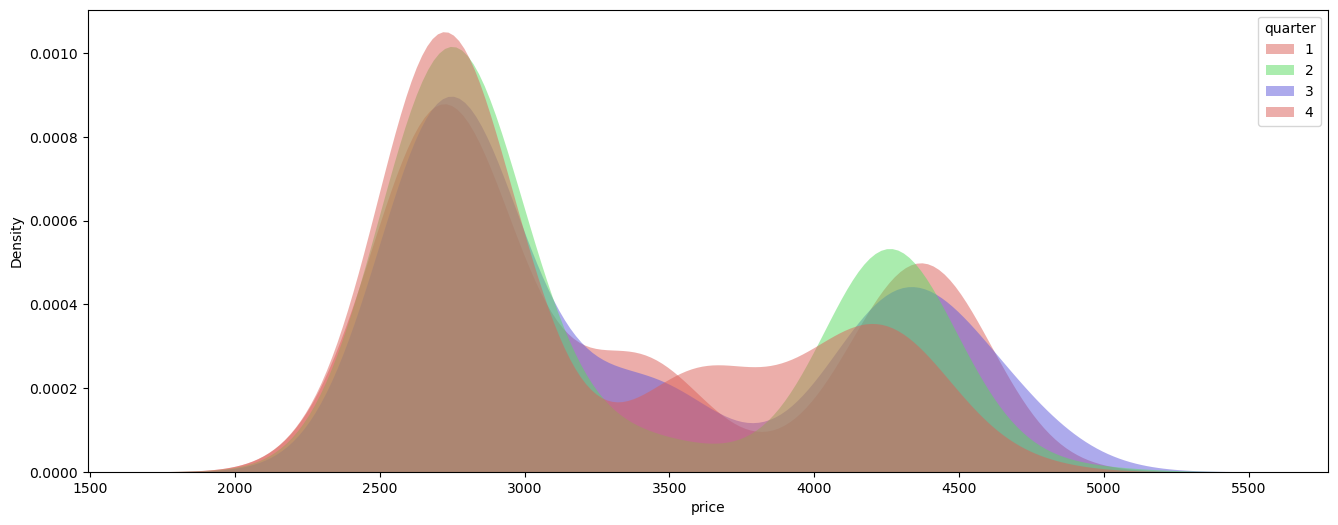

In [52]:
_, ax = plt.subplots(figsize=(16,6))
sns.kdeplot(ax=ax,data=df, x="price", hue="quarter",fill=True, common_norm=False, palette="hls", alpha=.5, linewidth=0,)
plt.show()

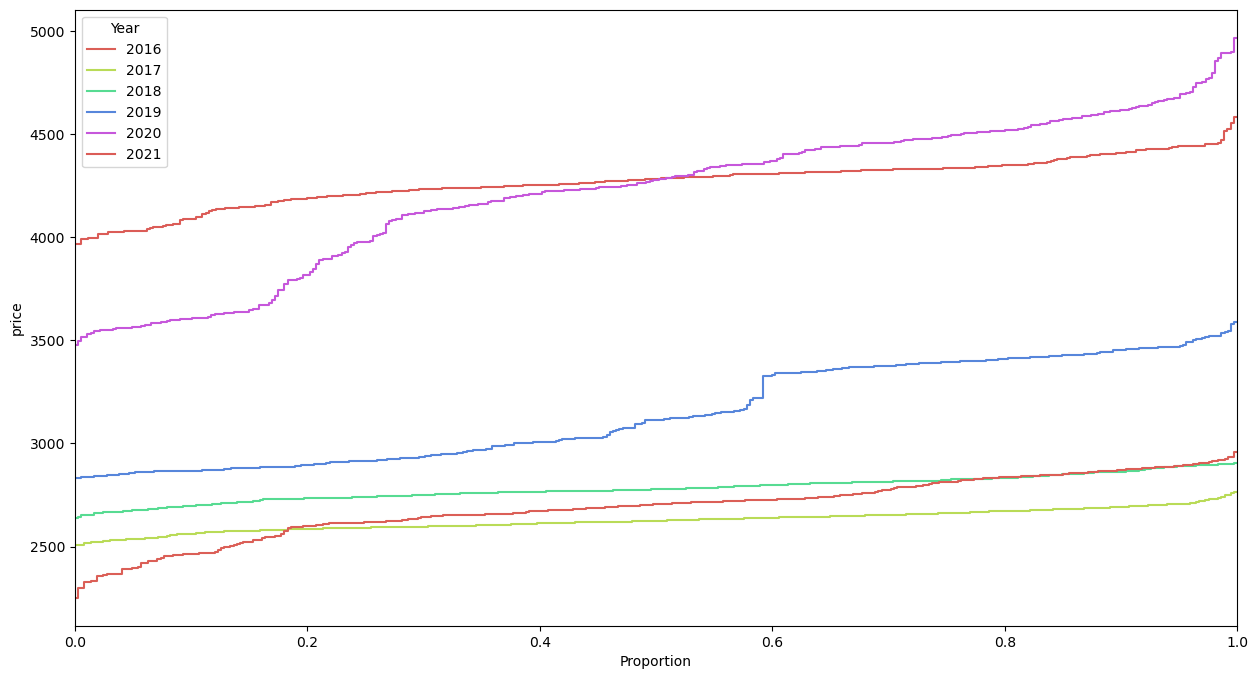

In [53]:
_, ax = plt.subplots(figsize=(15,8))
sns.ecdfplot(data=df, y="price",ax=ax,hue='Year',palette="hls")
plt.show()

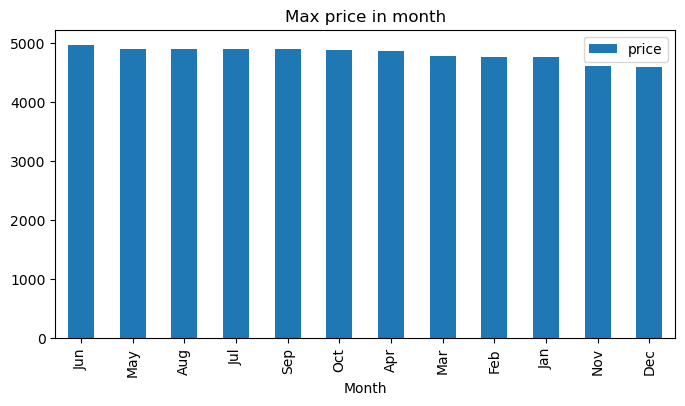

In [54]:
_, ax = plt.subplots(figsize=(8,4))
dfm=df.groupby(['Month']).max().sort_values(by='price',ascending=False).plot.bar(y='price',ax=ax,title='Max price in month')

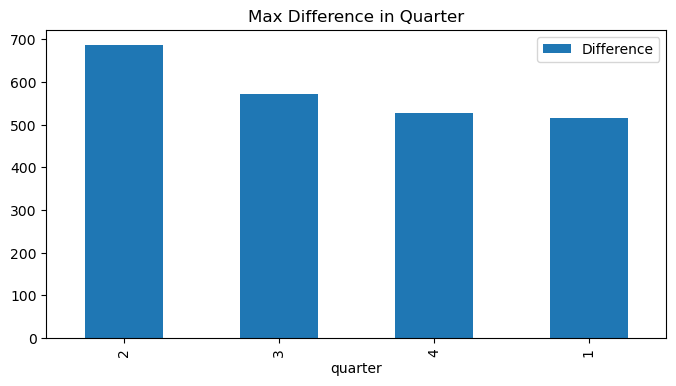

In [55]:
_, ax = plt.subplots(figsize=(8,4))
dfq=df.groupby(['quarter']).max().sort_values(by='price',ascending=False).plot.bar(y='Difference',ax=ax,title='Max Difference in Quarter')

In [56]:
dfdate=df[['date','price']]
dfdate.set_index('date', inplace=True)

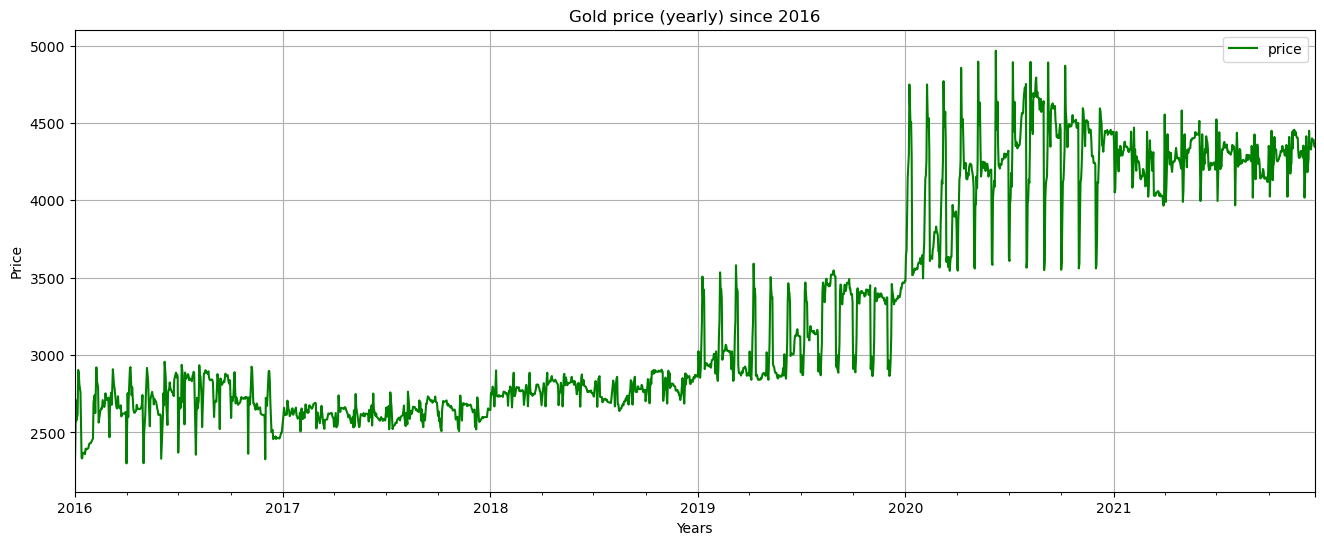

In [57]:
#data.plot(kind ='line',x = 'date', y = 'price', figsize = (16,8), marker = 'o')
dfdate.plot(figsize=(16,6),color='green')
plt.title("Gold price (yearly) since 2016")
plt.xlabel("Years")
plt.ylabel("Price")
plt.grid();

In [58]:
dfqd=df[['quarter','Difference']]
dfqd.set_index('quarter',inplace=True)

ValueError: cannot reindex on an axis with duplicate labels

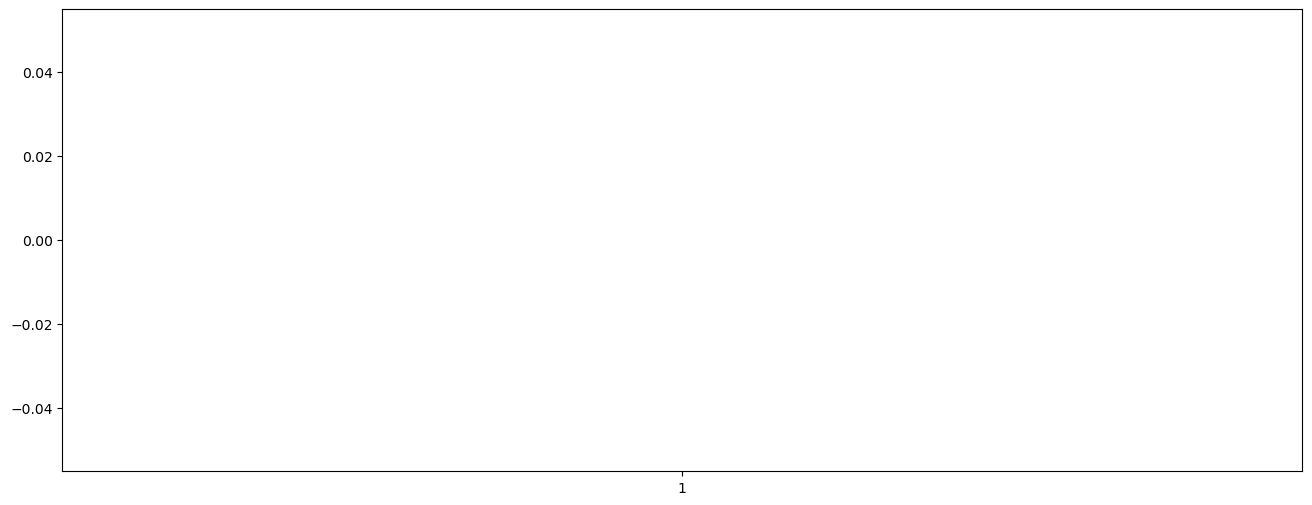

In [59]:
_, ax = plt.subplots(figsize=(16,6))
sns.stripplot(x = dfqd.index,y = dfqd.Difference,ax=ax)
plt.title("Gold price Difference in each quarter")
plt.xlabel("Quarters")
plt.ylabel("Difference")
plt.grid();

### For 2020 year 

In [60]:
df2020=df[['Month','price','Year','dayno']]
df2020=df2020[df2020['Year']==2020]
df2020=df2020.drop('Year',axis=1)
df2020.set_index('Month',inplace=True)

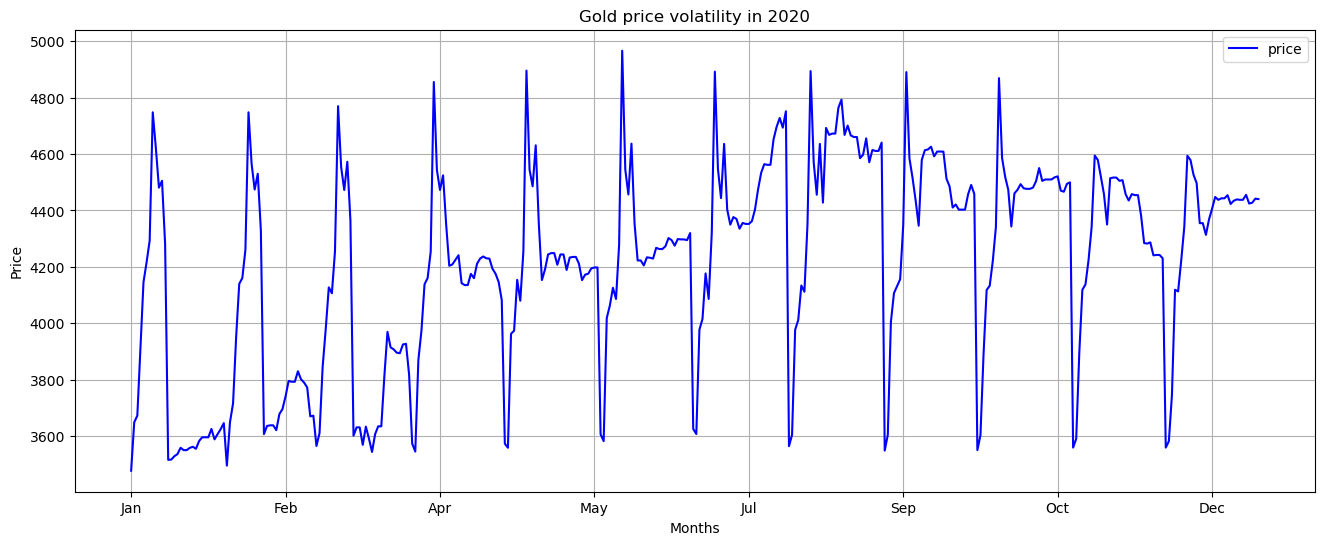

In [61]:
df2020[['price']].plot(figsize=(16,6),color='blue')
plt.title("Gold price volatility in 2020")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

### For 2020 January month

In [62]:
df2020_jan=df2020[df2020.index=='Jan']
df2020_jan.set_index('dayno',inplace=True)

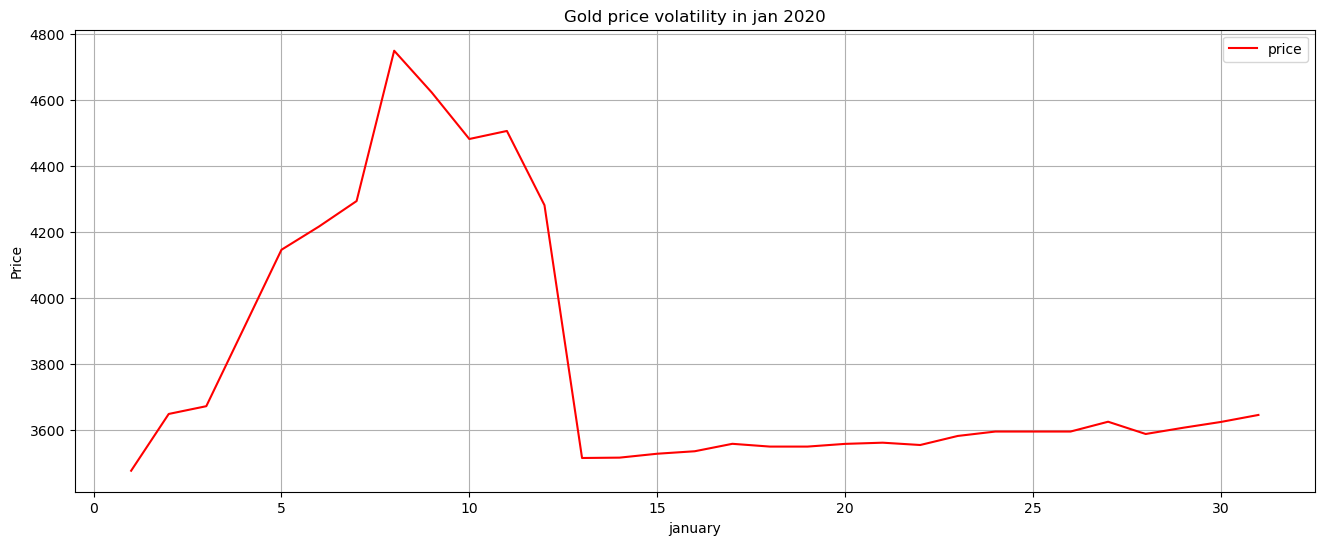

In [63]:
df2020_jan[['price']].plot(figsize=(16,6),color='red')
plt.title("Gold price volatility in jan 2020")
plt.xlabel("january")
plt.ylabel("Price")
plt.grid();

In [64]:
dfmonths=df.groupby('Month')[['price','Difference']].std()
dfmonths=dfmonths.reset_index()

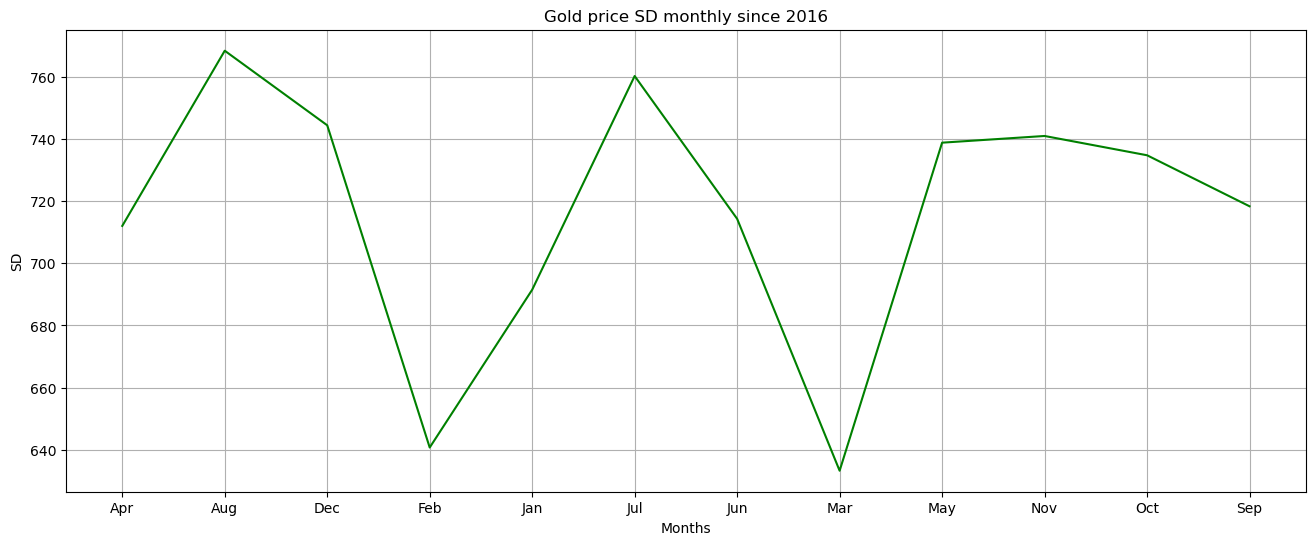

In [65]:
_, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x ='Month',y='price',data=dfmonths,ax=ax,color='green')
plt.title("Gold price SD monthly since 2016")
plt.xlabel("Months")
plt.ylabel("SD")
plt.grid();

<AxesSubplot: xlabel='Year', ylabel='price'>

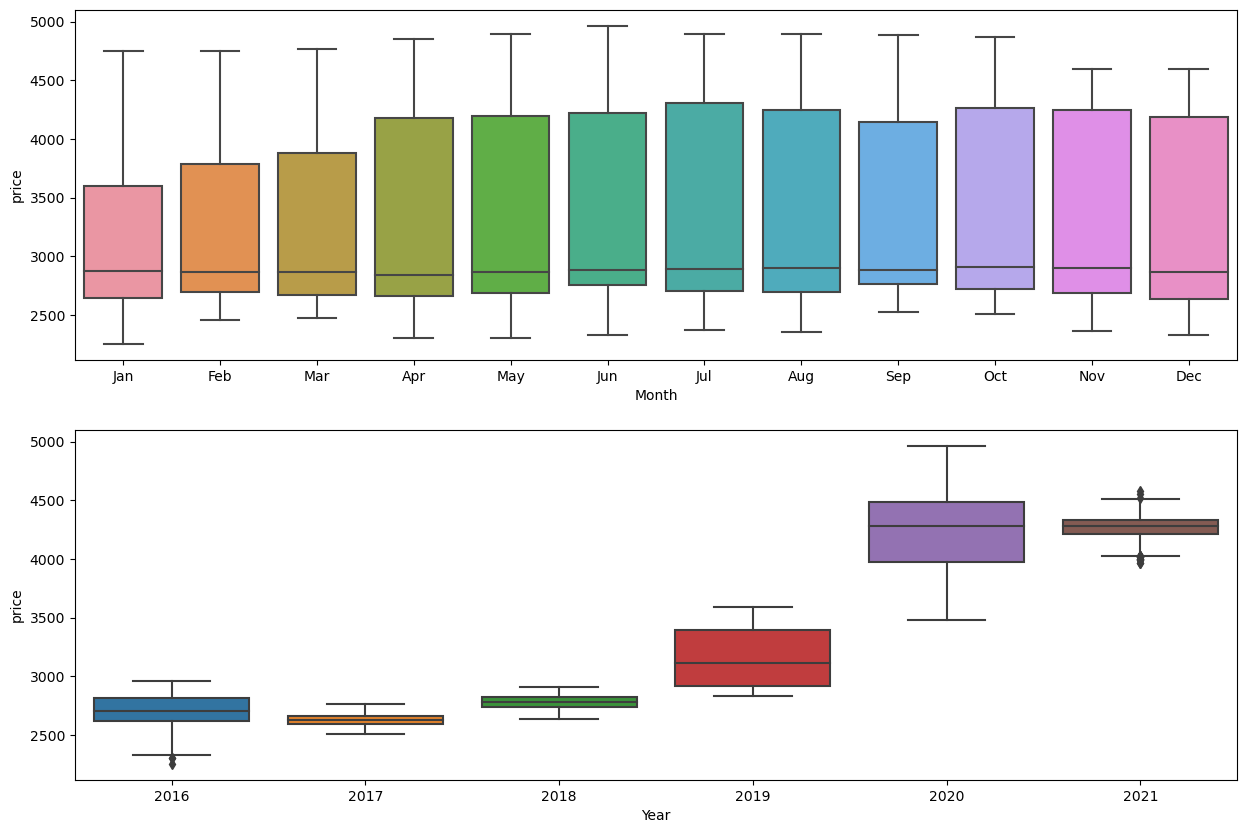

In [66]:
# Box Plot of each year month intervals
plt.figure(figsize=(15,10))
plt.subplot(211)
sns.boxplot(x='Month',y="price",data=df)
plt.subplot(212)
sns.boxplot(x='Year',y="price",data=df)


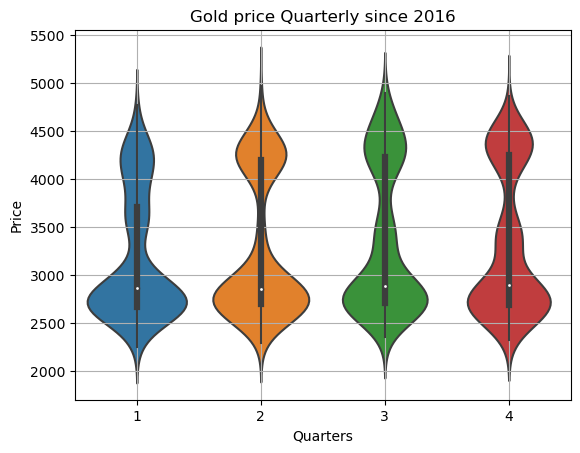

In [67]:
sns.violinplot(x='quarter',y="price",data=df)
plt.title("Gold price Quarterly since 2016")
plt.xlabel("Quarters")
plt.ylabel("Price")
plt.grid();

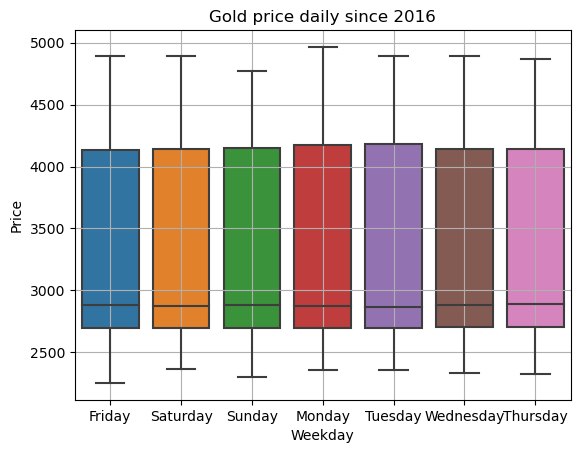

In [68]:
sns.boxplot(x='day_of_week',y="price",data=df)
plt.title("Gold price daily since 2016")
plt.xlabel("Weekday")
plt.ylabel("Price")
plt.grid();

In [69]:
dfd=df[['dayno','price']]
dfd.set_index('dayno',inplace=True)

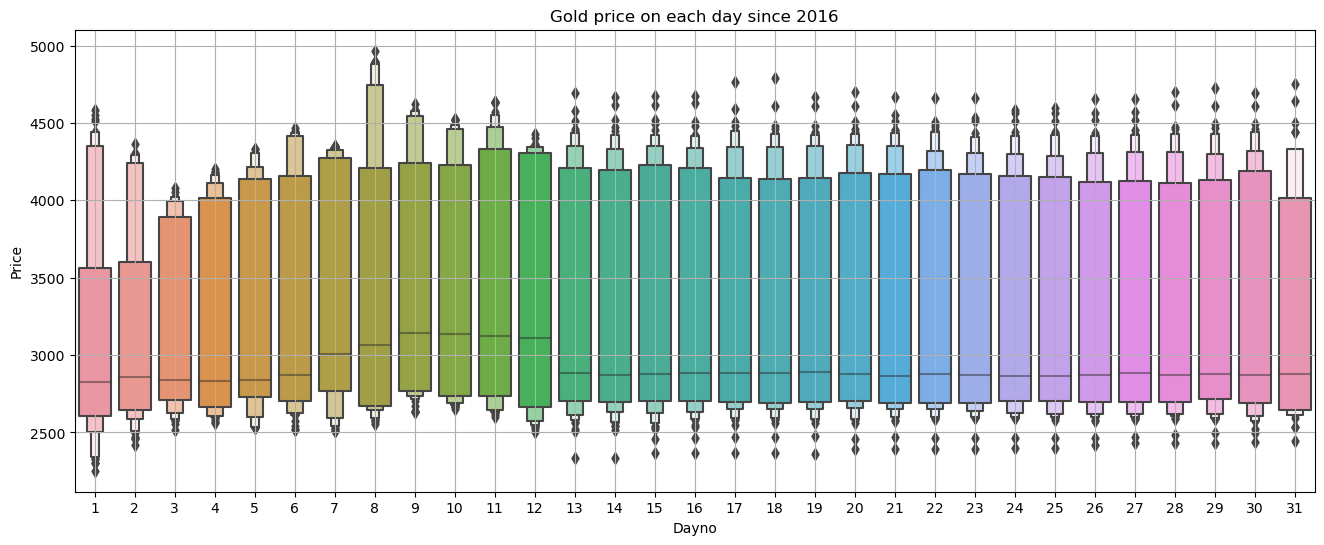

In [70]:
_, ax = plt.subplots(figsize=(16,6))
sns.boxenplot(x = dfd.index,y = dfd.price,ax=ax)
plt.title("Gold price on each day since 2016")
plt.xlabel("Dayno")
plt.ylabel("Price")
plt.grid();

In [71]:
dfs=df[['Difference','price','change']]
dfs=dfs.iloc[1:]
dfs

,Difference,price,change
1,201.90,2454.50,0.089630
2,253.60,2708.10,0.103320
3,-130.30,2577.80,-0.048115
4,19.95,2597.75,0.007739
5,19.95,2617.70,0.007680
...,...,...,...
2177,-5.40,4394.40,-0.001227
2178,-4.90,4389.50,-0.001115
2179,0.00,4389.50,0.000000
2180,-35.40,4354.10,-0.008065


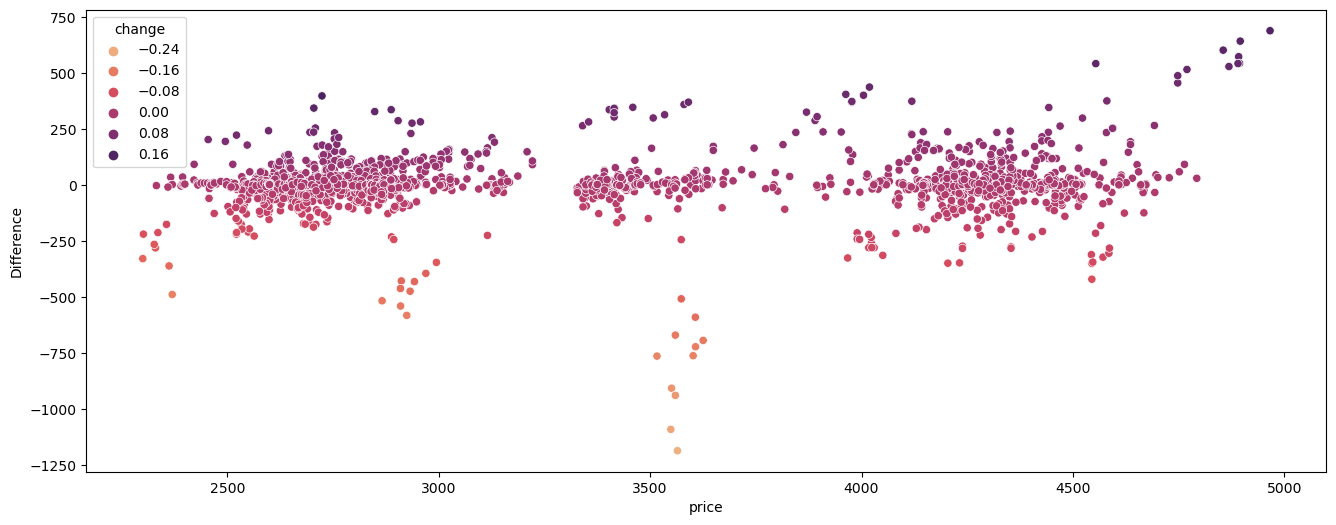

In [72]:
_, ax = plt.subplots(figsize=(16,6))
sns.scatterplot(x='price',y='Difference',hue='change',palette="flare",data=dfs,ax=ax)
plt.show()

In [73]:
df.head()

,date,price,Month,Year,quarter,dayno,day_of_week,change,Difference
0,2016-01-01,2252.60,Jan,2016,1,1,Friday,NaN,NaN
1,2016-01-02,2454.50,Jan,2016,1,2,Saturday,0.089630,201.90
2,2016-01-03,2708.10,Jan,2016,1,3,Sunday,0.103320,253.60
3,2016-01-04,2577.80,Jan,2016,1,4,Monday,-0.048115,-130.30
4,2016-01-05,2597.75,Jan,2016,1,5,Tuesday,0.007739,19.95


<AxesSubplot: xlabel='Month', ylabel='Year'>

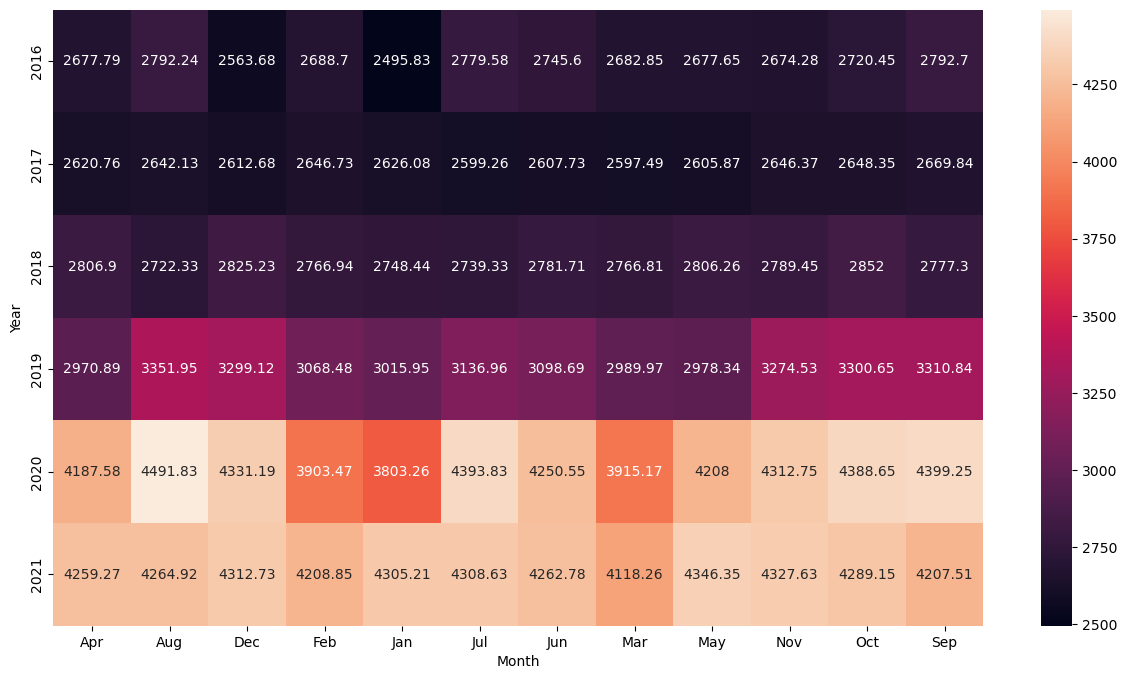

In [74]:
# Heatmap
plt.figure(figsize=(15,8))
y_m=pd.pivot_table(data=df,values='price',index='Year',columns='Month',aggfunc="mean",fill_value=0)
sns.heatmap(y_m,annot=True,fmt='g')

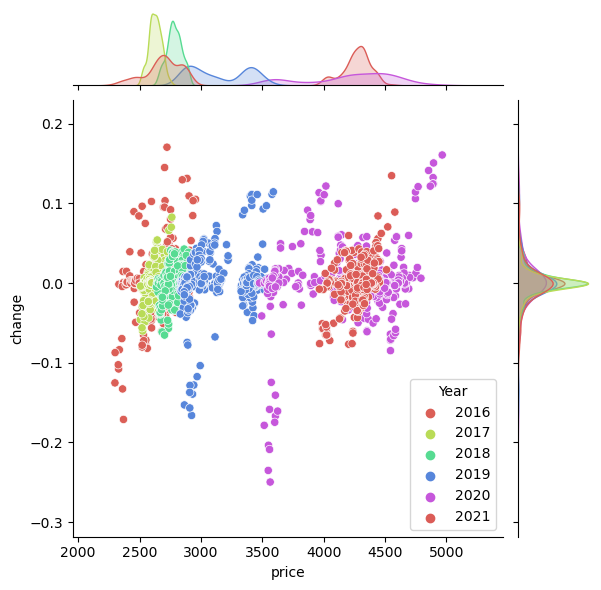

In [75]:
sns.jointplot(data=df, x="price", y="change", hue="Year",palette="hls")
plt.show()

<AxesSubplot: xlabel='Month', ylabel='price'>

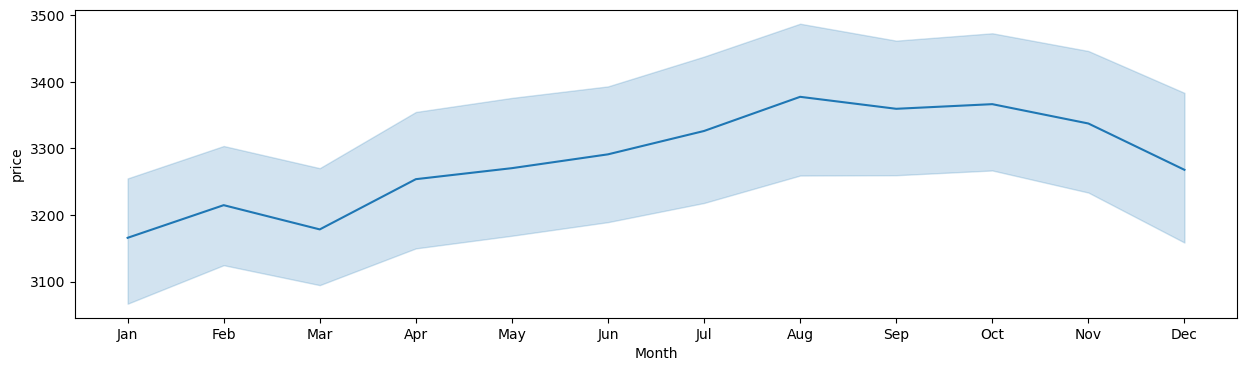

In [76]:
plt.figure(figsize=(15,4))
sns.lineplot(x='Month',y="price",data=df)

<AxesSubplot: xlabel='Year', ylabel='price'>

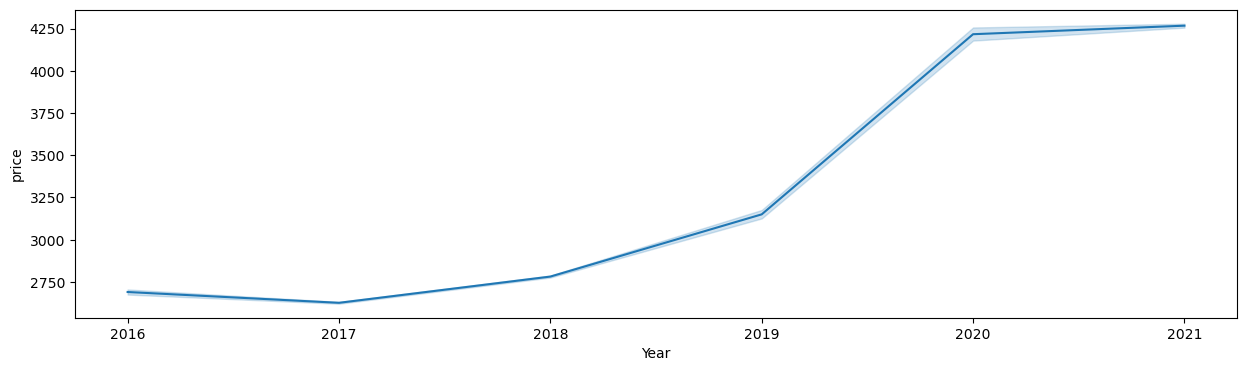

In [77]:
plt.figure(figsize=(15,4))
sns.lineplot(x='Year',y="price",data=df)

<AxesSubplot: xlabel='quarter', ylabel='price'>

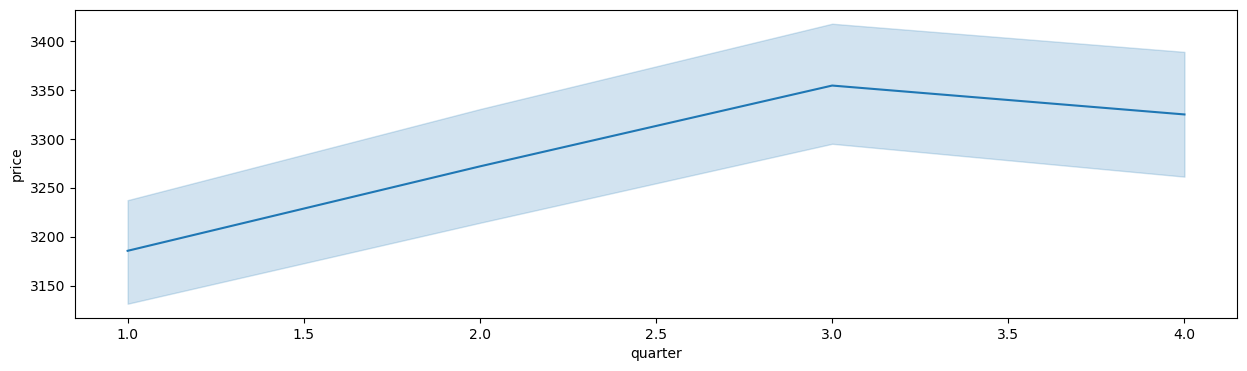

In [78]:
plt.figure(figsize=(15,4))
sns.lineplot(x='quarter',y="price",data=df)

<AxesSubplot: xlabel='day_of_week', ylabel='price'>

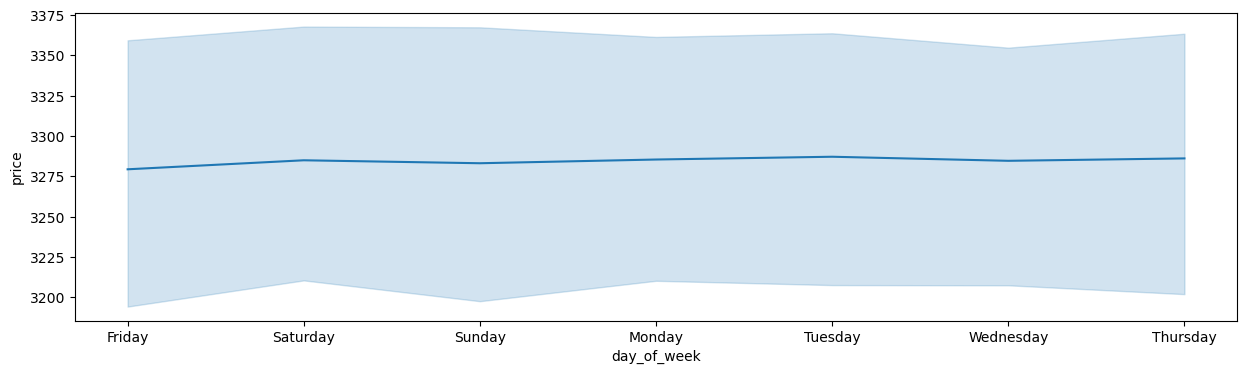

In [79]:
plt.figure(figsize=(15,4))
sns.lineplot(x='day_of_week',y="price",data=df)

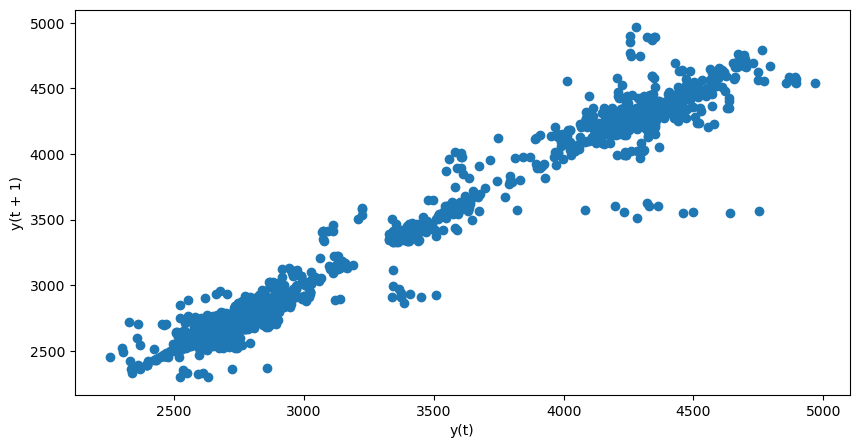

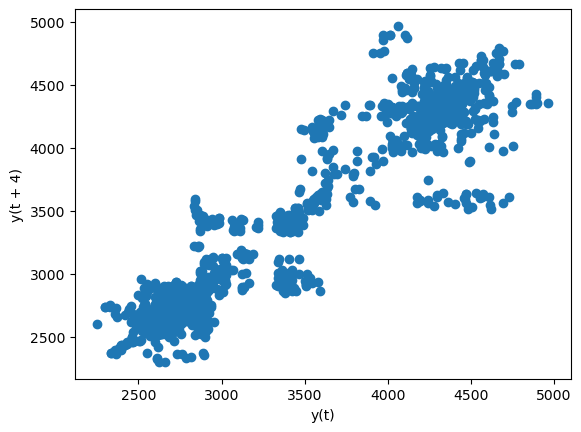

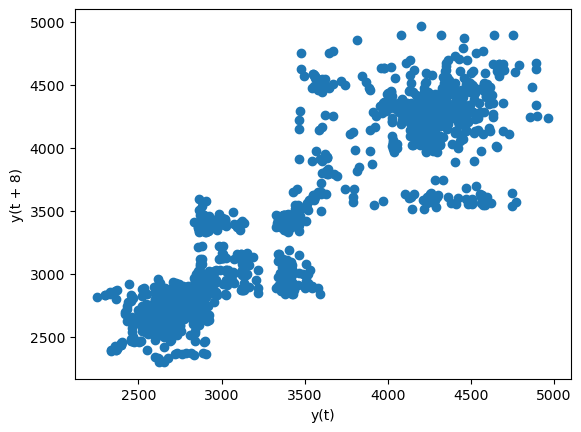

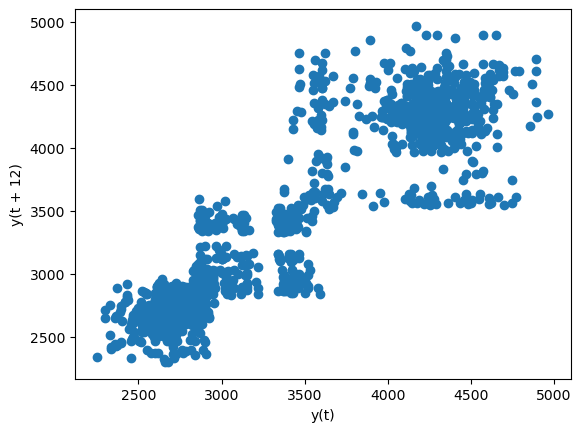

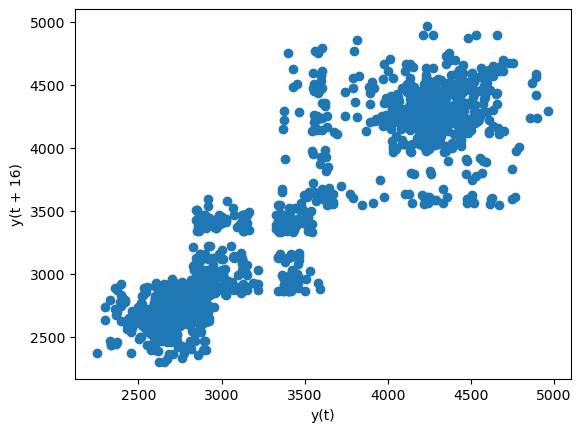

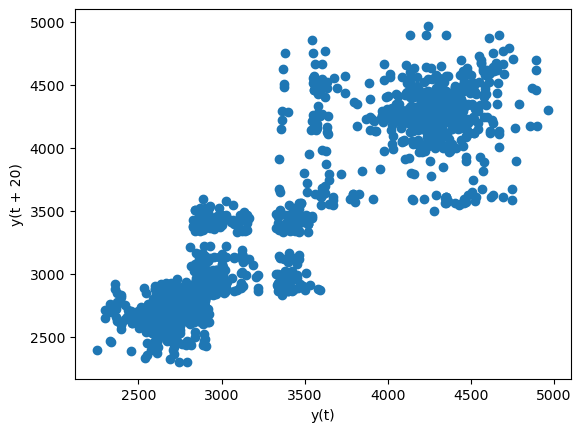

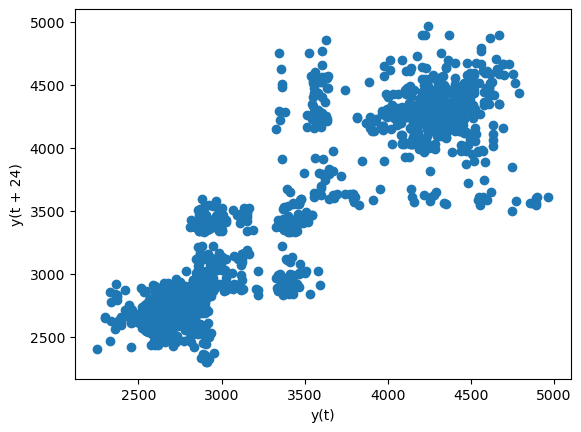

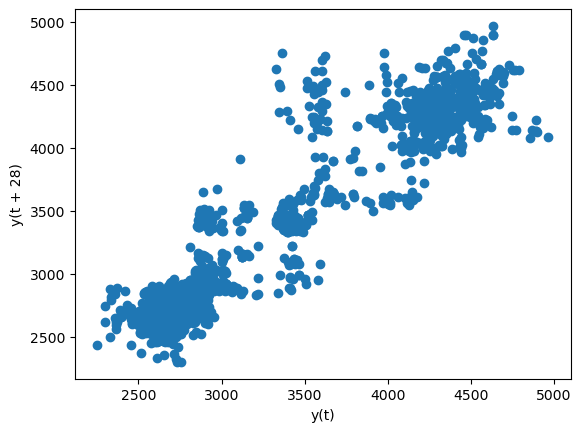

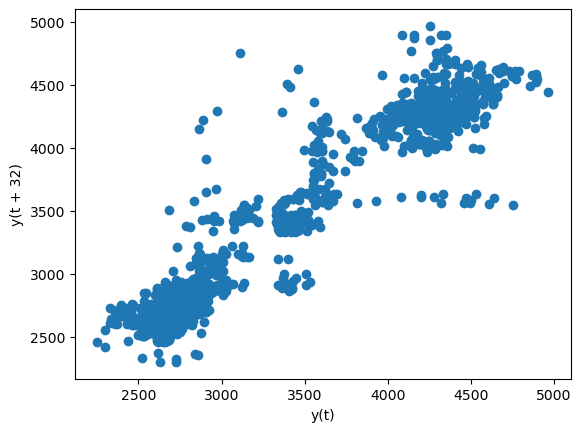

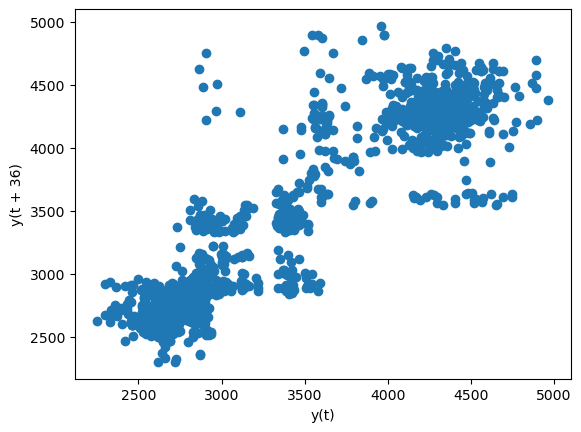

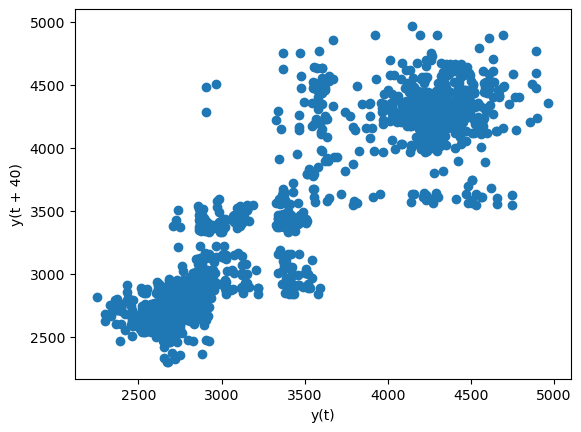

In [80]:
# Lag plot
plt.figure(figsize=(10,5))
for i in [1,4,8,12,16,20,24,28,32,36,40]:
    lag_plot(df.price,lag=i)
    plt.show()

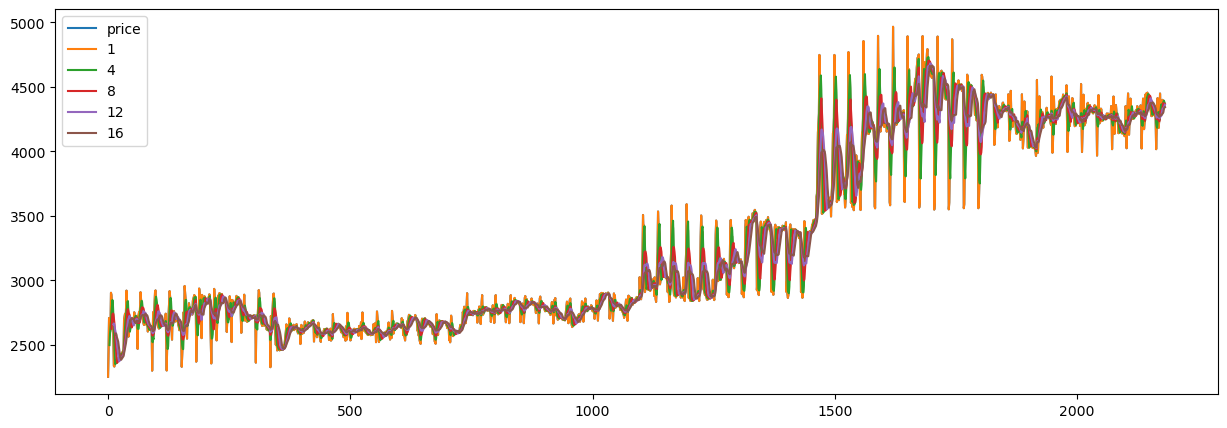

In [81]:
#Moving Average
plt.figure(figsize=(15,5))
df['price'].plot()
for i in [1,4,8,12,16]:
    df['price'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [82]:
df1=data.copy()
df1.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [83]:

df1['date']=pd.to_datetime(df['date'])
df1.set_index('date',inplace=True)
df1.head()

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75


In [84]:
df1=df1.resample('1M').mean()

In [85]:
df1.head() 

,price
date,
2016-01-31,2495.832258
2016-02-29,2688.703448
2016-03-31,2682.854839
2016-04-30,2677.790000
2016-05-31,2677.650000


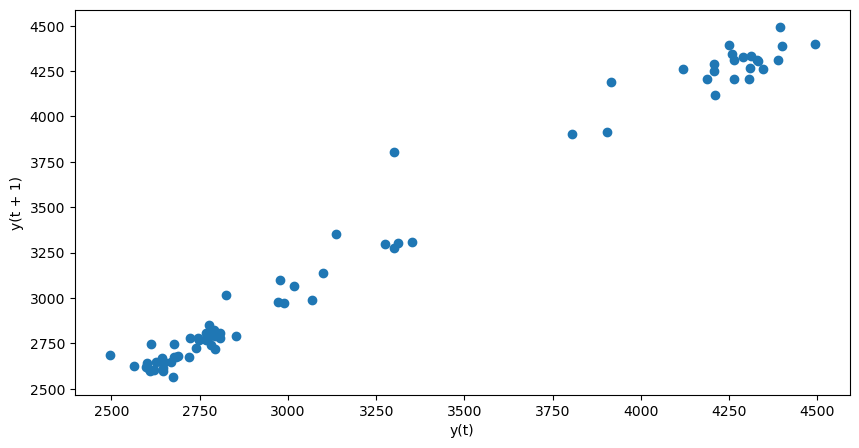

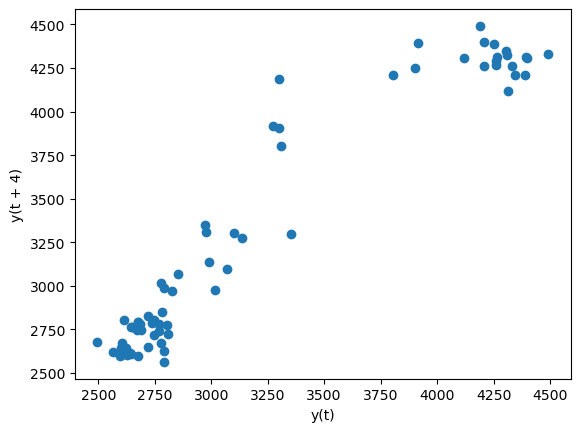

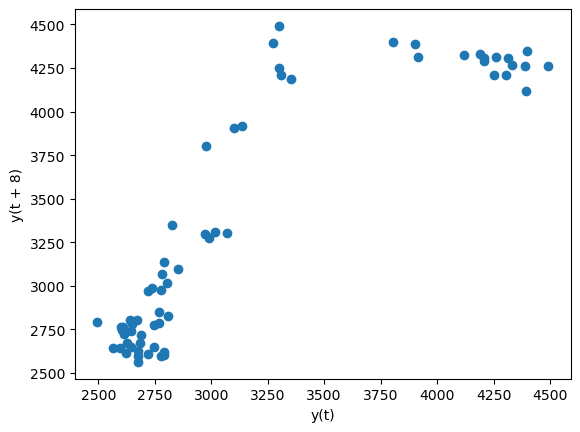

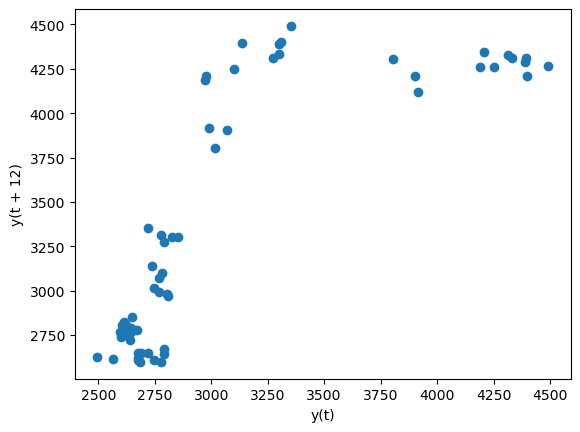

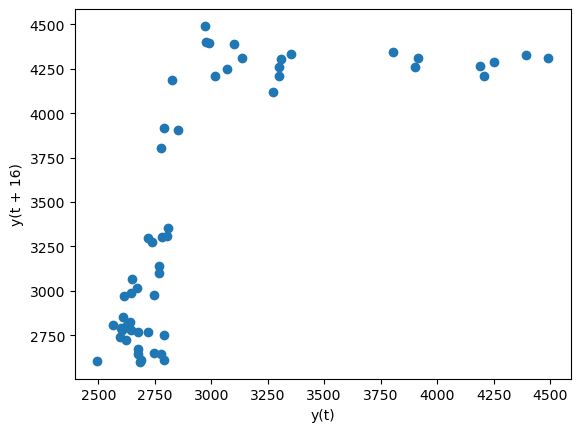

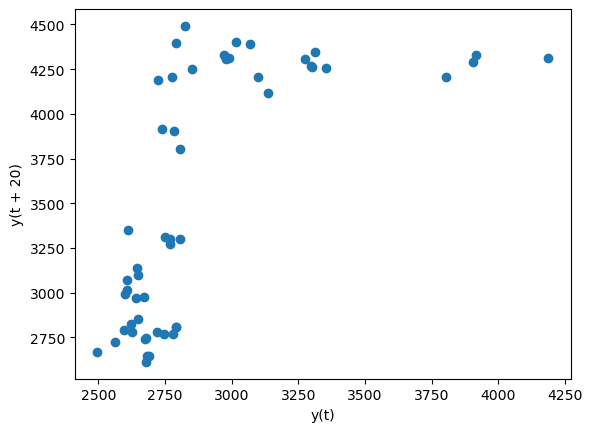

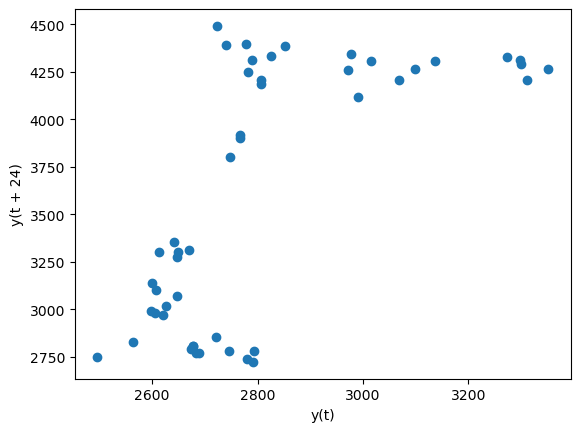

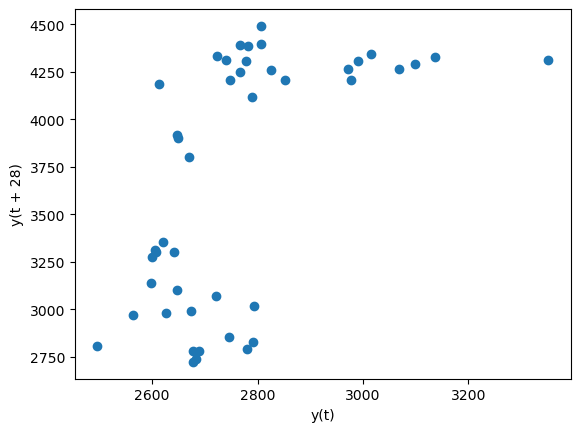

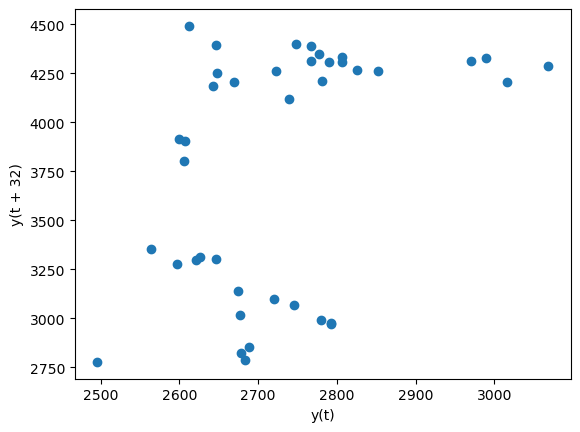

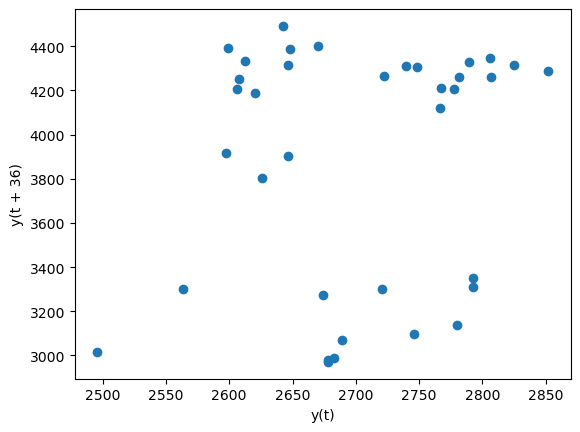

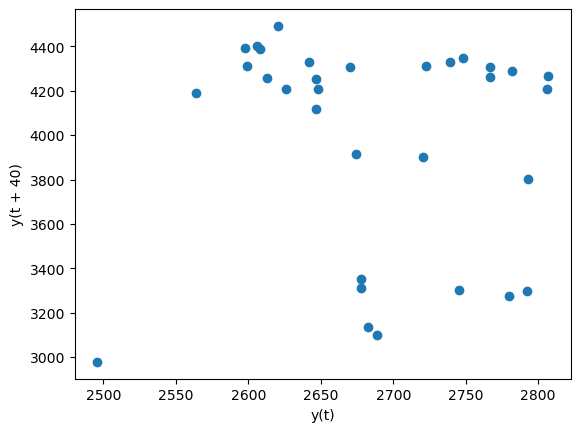

In [86]:
# Lag plot for monthly mean
plt.figure(figsize=(10,5))
for i in [1,4,8,12,16,20,24,28,32,36,40]:
    lag_plot(df1.price,lag=i)
    plt.show()

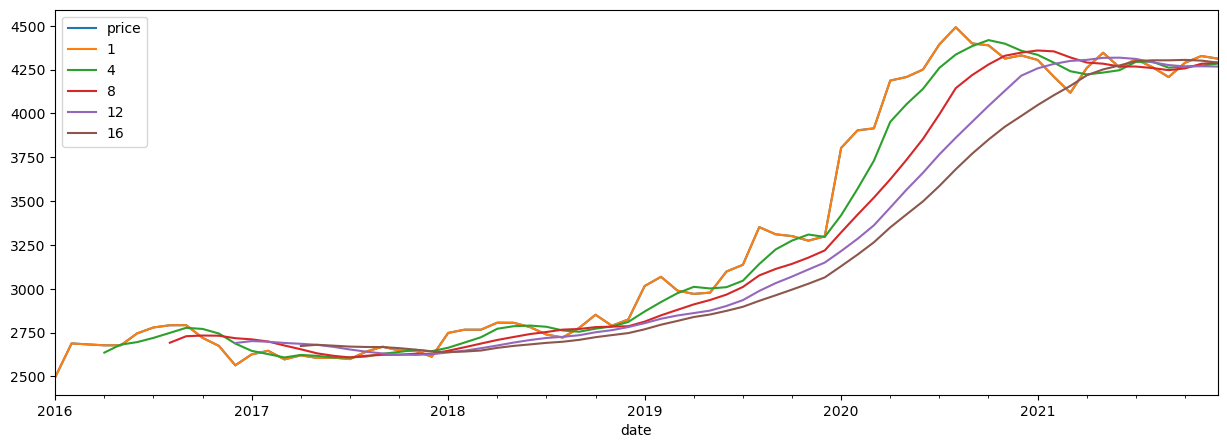

In [87]:
#Moving Average for monthly mean
plt.figure(figsize=(15,5))
df1['price'].plot()
for i in [1,4,8,12,16]:
    
    df1['price'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

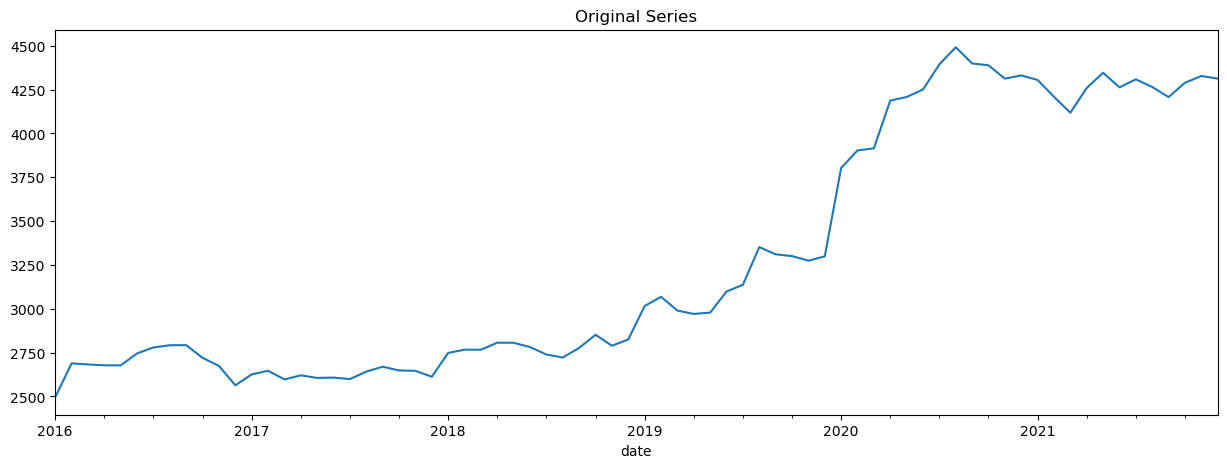

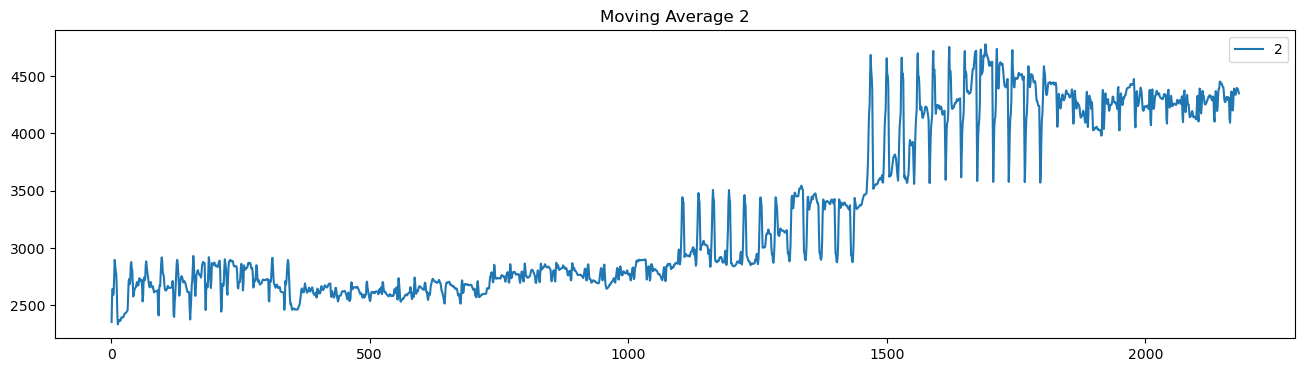

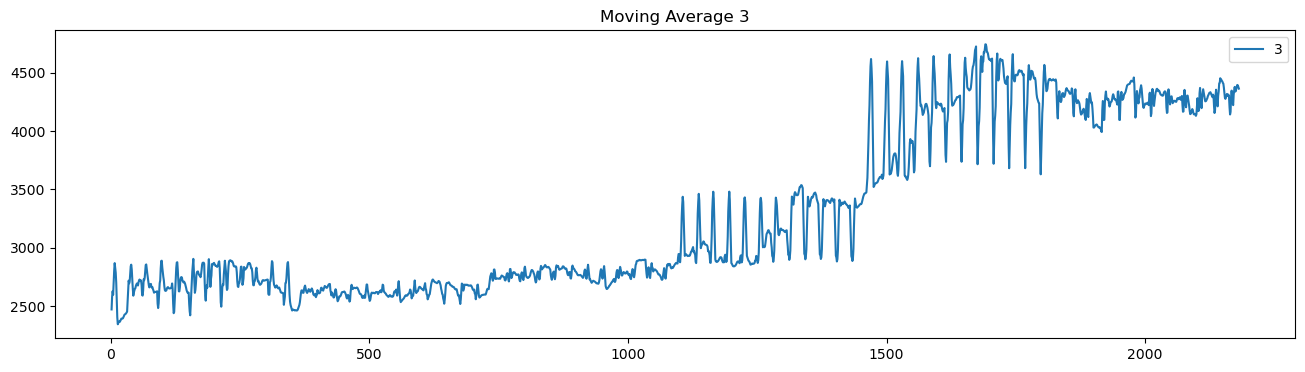

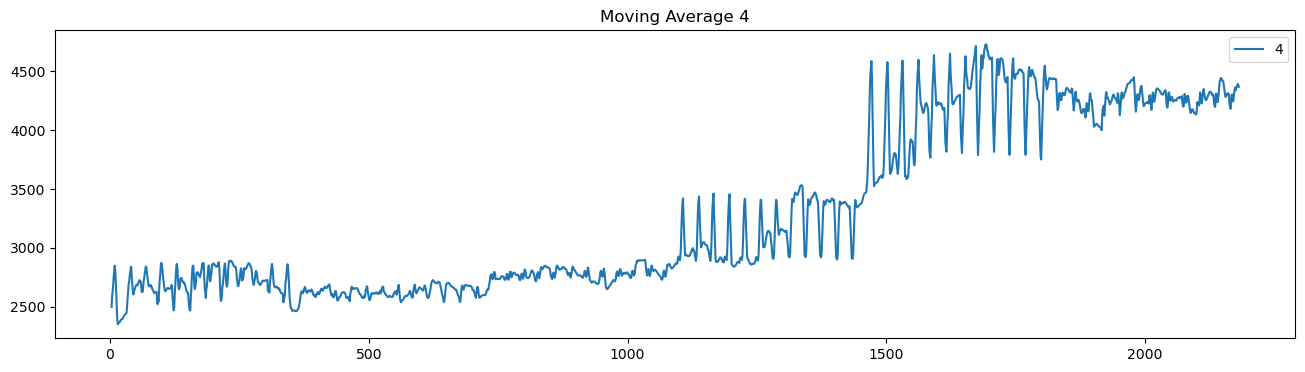

In [88]:
plt.figure(figsize=(15,5))
df1['price'].plot()
plt.title("Original Series")
for i in [2,3,4]:
    plt.figure(figsize=(16,4))
    df["price"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

# Time-Series Decomposition

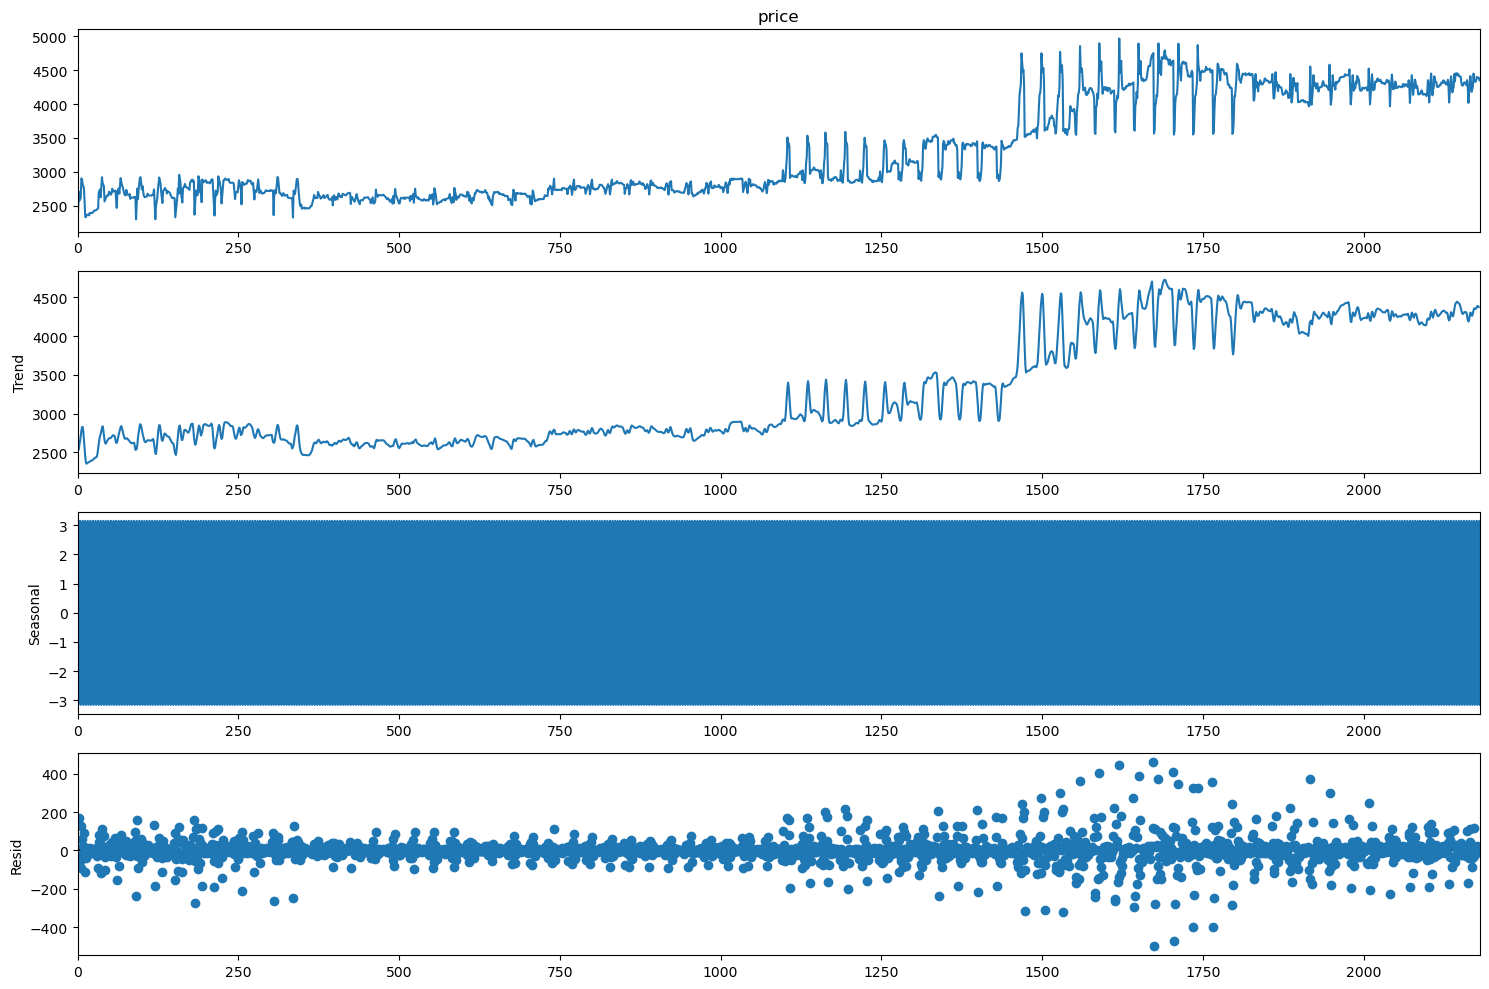

In [89]:
#Time Series decomposition plot
decompose_ts_add=seasonal_decompose(df['price'],period=4)
with plt.rc_context():
    plt.rc('figure',figsize=(15,10))
    decompose_ts_add.plot()
    plt.show()

### Additive Seasonal Decompose

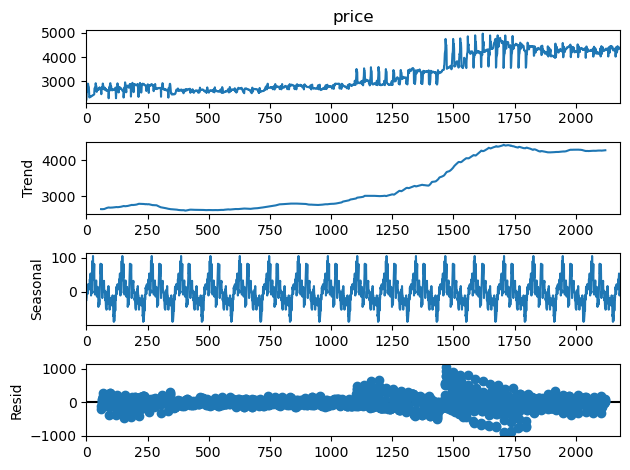

In [90]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = sm.tsa.seasonal_decompose(df['price'], model='additive',period=120)
fig = decomposition.plot()
plt.show()

**Analysis:- Observed - Actual data**
- Trend - Increasing or decreasing trend.
- Seasonal - Varies from +0.5 to -0.5 with the mean 0. Each cycle represents each year trend. The value in the Y-axis has to be added to the Trend plot value to get the actual value of that year. E.g.:- For the year 1988 Nov, the seasonal value is +0.5 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 0.5+100 = 100.5

- Residual - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)
## Multiplicative Seasonal Decomposition

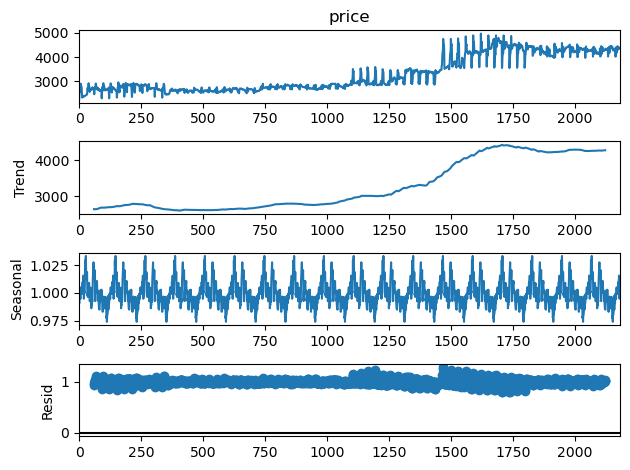

In [91]:
decomposition = sm.tsa.seasonal_decompose(df['price'], model='multiplicative',period=120)
fig = decomposition.plot()
plt.show()

# PACFand ACF plot

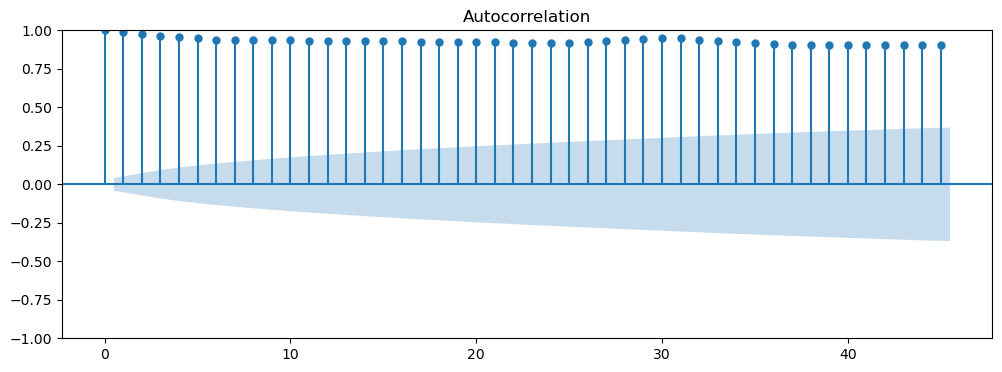

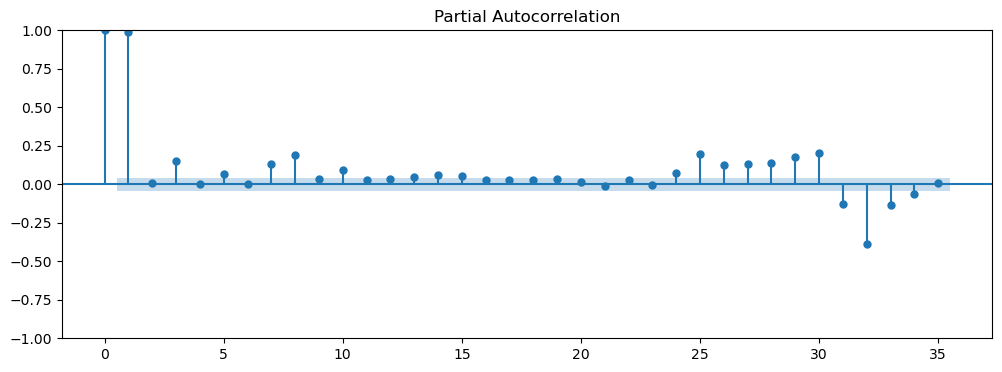

In [92]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.price,lags=45)
    tsa_plots.plot_pacf(df.price,lags=35)
    plt.show()

### Monthwise yearly Price

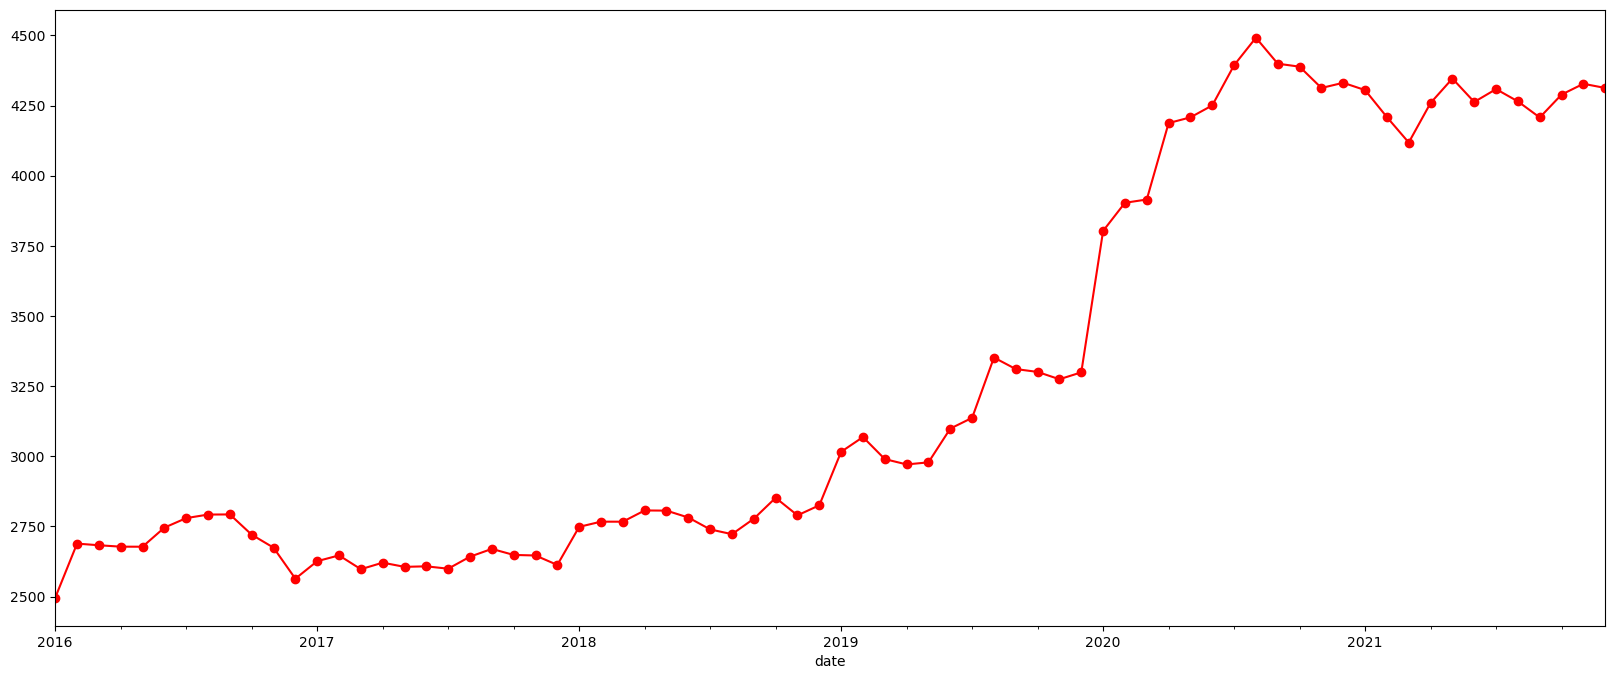

In [93]:
df1['price'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

In [94]:
df_eda=df.copy()
df_eda.set_index('date',inplace=True)
df_eda.tail()

,price,Month,Year,quarter,dayno,day_of_week,change,Difference
date,,,,,,,,
2021-12-17,4394.4,Dec,2021,4,17,Friday,-0.001227,-5.4
2021-12-18,4389.5,Dec,2021,4,18,Saturday,-0.001115,-4.9
2021-12-19,4389.5,Dec,2021,4,19,Sunday,0.000000,0.0
2021-12-20,4354.1,Dec,2021,4,20,Monday,-0.008065,-35.4
2021-12-21,4346.5,Dec,2021,4,21,Tuesday,-0.001745,-7.6


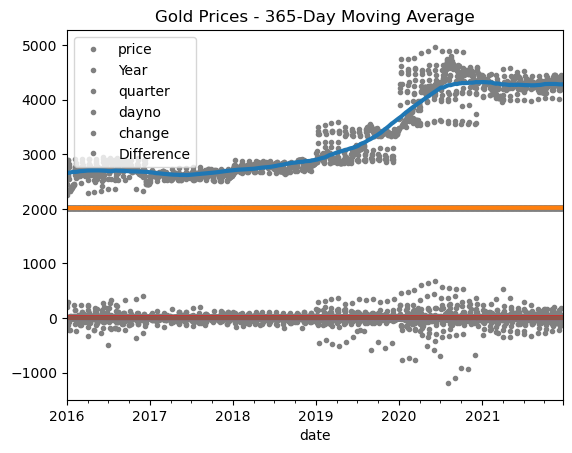

In [95]:
# Visualizing changes in mean over 365 days.
moving_average = df_eda.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df_eda.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Gold Prices - 365-Day Moving Average", legend=False,
);

## Check for Stationary or Non-Stationary Time-series
**1)Augmented Dickey-Fuller (ADF) Test**
- Null Hypothesis (H0): The series is not stationary
p-val > 0.05
- Alternate Hypothesis (H1): The series is stationary
p-val <= 0.05

In [96]:
result=adfuller (df['price'])
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -0.309904
p-value: 0.924090
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


 **Analysis**
- p-value (0.92) > critical value(0.05).
- Failed to reject null hypothesis (The series is not stationary)
- Hence, the time series is Non-Stationary.

## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
- Null Hypothesis (H0): The series is stationary

p-val>0.05

- Alternate Hypothesis (H1): The series is not stationary

p-val <= 0.05

In [97]:
from statsmodels.tsa.stattools import kpss
result_kpss_ct=kpss(df['price'],regression="ct")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 1.284096
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


**Analysis**
- p-val(0.01) < Critical value(0.05) Reject the null hypothesis (The series is stationary)
- Hence, as per alternate hypothesis the time series is non stationary
## Converting Non-Stationary to Stationary Time Series
To make our Data Stationary We apply Some Methods
-**Transformation**
- i) Log Tranformation
- ii) Square root Transformation
- iii) Log Differencing Method
- iv) Square root differencing

**i) Log transforming of the data**

In [98]:
df_log=np.log(df['price'])
df_diff=df_log.diff().dropna()
df_compare=df_log
df_log.head()

0    7.719840
1    7.805678
2    7.904003
3    7.854692
4    7.862401
Name: price, dtype: float64

In [99]:
df_log.shape

(2182,)

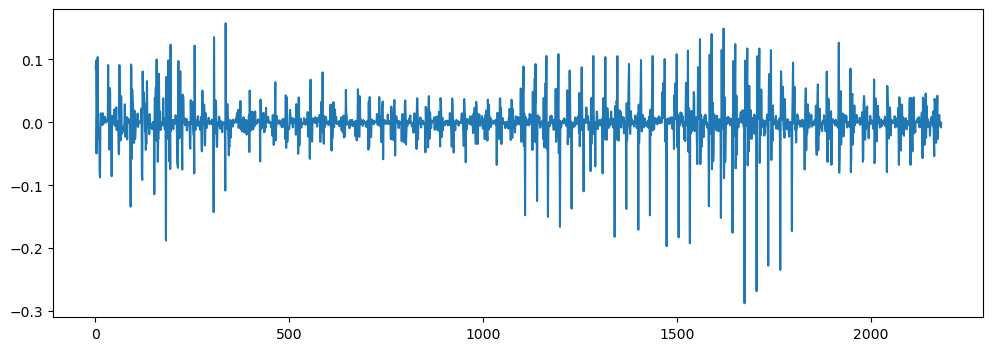

In [100]:
df_diff.plot(figsize=(12,4))
plt.show()

In [101]:
# using ADF test
result=adfuller (df_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -21.394232
p-value: 0.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


**Analysis:**

- Test Statistic > Critical Value and
- p-value < 0.05.

In [102]:
# Using KPSS Test
result_kpss_ct_log=kpss(df_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.030000
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


**Analysis**
- Test Statistic > Critical Value and p-value < 0.05.
- here looks Reversed 0.020000 < 0.146 and 0.100000 < 0.05
- From this we conclude that our data is stationary.

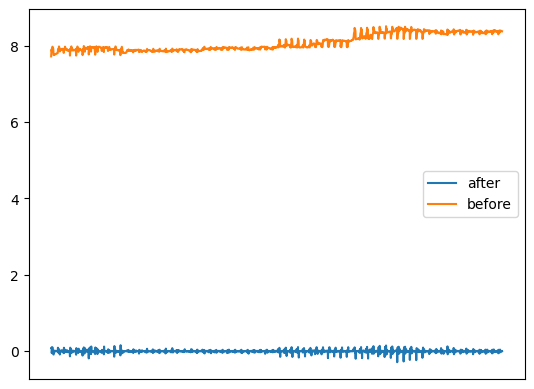

In [103]:
# Comparing both test Before Transformation and After Transformation
plt.plot(df_diff,label="after")
plt.plot(df_compare,label="before")
plt.tick_params(
    axis='x',        
    which='both',   
    bottom=False,      
    top=False,        
    labelbottom=False)
plt.legend()
plt.show() 

In [104]:
# To find information of maximum price
df[df['date']=='2020-12-01']

,date,price,Month,Year,quarter,dayno,day_of_week,change,Difference
1796,2020-12-01,3559.6,Dec,2020,4,1,Tuesday,-0.158606,-671.0


In [105]:
size = 1796
train_data = df[:size]
test_data = df[size:]

In [106]:
print(train_data.shape)
print(test_data.shape)

(1796, 9)
(386, 9)


In [107]:
# Evaluation metric
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Simple Exponential

In [110]:
# Simple exponential
ses_model = SimpleExpSmoothing(train_data['price']).fit(optimized=True)
test_pred_ses = ses_model.forecast(386)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.price))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.price)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [ ]:
# double exponential
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(386)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.price))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.price)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
- Captures Level, Trend and Seasonality.

In [ ]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(386)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.price))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.price)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

## Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)


In [ ]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(386)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.price))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.price)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [ ]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(386)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.price))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.price)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [ ]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(12)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.price))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.price)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [ ]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

In [ ]:
from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA


In [ ]:
differencing.head()

In [ ]:
from prophet import Prophet

In [ ]:
p = Prophet(interval_width=0.92, daily_seasonality=True)

In [ ]:
df2=data.copy()
df2.dtypes

In [ ]:
df2

In [ ]:
df2.columns = ['ds', 'y']
df2.head()

In [ ]:
model = p.fit(df2)

In [ ]:
forecast_prediction = p.predict(df2)
forecast_prediction.tail()

In [ ]:
plot1 = p.plot(forecast_prediction)

In [ ]:
plot2 = p.plot_components(forecast_prediction)

In [ ]:
print(forecast_prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast_prediction)
plt.show()

In [ ]:
future1 = p.make_future_dataframe(periods=30)

In [ ]:
forecast1 = p.predict(future1)

In [ ]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
p.plot(forecast1);

In [ ]:
p.plot_components(forecast1);

Conclusion
So, this is how one can use the Fbprophet library to easily predict future time series data without wasting much time on tuning the model. There is also a provision to perform cross-validation with the help of the Prophet library which helps in increasing the accuracy of predictions.